# Base Model

Blog: https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8

Source code: https://github.com/hlamba28/Automatic-Image-Captioning

**Jump to section 12 for evaluation metrices. Need to execute sections 1,2,4, and 5 before that.**

In [1]:
# import necessary packages
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization, GRU
from keras.optimizers import Adam, RMSprop, SGD
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


## 1 - Load, clean, save captions


Load the text file containing all the image id's and captions. The data is in the file called "Flickr8k.token.txt" in the text zip file. We create a function load_doc to do this, so we can use it inside later functions.

In [ ]:
# Execute only if running the code first time
#!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

In [ ]:
# Execute only if running the code first time
#!unzip Flickr8k_text.zip

In [2]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = 'data/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


As we can see from the output, we have in each line  the image id, the caption number and the caption itself.

We want to spilt each line into key value pairs, with the keys being image id's and the values being a list of captions 0-4.

In [3]:
# create load_description function that splits image id and captions as key value pairs in dictionary - mapping
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions (should be length of dataset 8092)
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [4]:
# check the first 5 keys
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

We need to remove punctuation and anything else not words, overwrite descriptions dictionary with cleaned version.

In [5]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [6]:
# check that it worked
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [7]:
descriptions['1001773457_577c3a7d70']

['black dog and spotted dog are fighting',
 'black dog and tricolored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

In [8]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'data/descriptions.txt')

We don't really use this cell for anything, bu tthe function could come in handy?

In [9]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


## 2 - Load, clean, save images

In [ ]:
# Execute only if running the code first time
#! wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip

In [ ]:
# Execute only if running the code first time
# !unzip data/Flickr8k_Dataset.zip 

In [10]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = 'data/Flickr_8k.trainImages.txt'
train = load_set(filename)

# load dev dataset (6K)
filename = 'data/Flickr_8k.devImages.txt'
dev = load_set(filename)


print('Dataset: %d' % len(train))
print('Dataset val: %d' % len(dev))

Dataset: 6000
Dataset val: 1000


In [11]:
# Below path contains all the images
images = 'data/Flicker8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

Save image filepaths to a list to call later in 

In [12]:
# Below file conatains the names of images to be used in train data
train_images_file = 'data/Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [13]:
# Below file conatains the names of images to be used in dev data
dev_images_file = 'data/Flickr_8k.devImages.txt'
# Read the validation image names in a set# Read the dev image names in a set
dev_images = set(open(dev_images_file, 'r').read().strip().split('\n'))

# Create a list of all the dev images with their full path names
dev_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in dev_images: # Check if the image belongs to dev set
        dev_img.append(i) # Add it to the list of dev images

In [14]:
# Below file conatains the names of images to be used in test data
test_images_file = 'data/Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

## 3 - Extract image features

The CNN prebuilt model used is InceptionV3, with imagenet weights.

In [ ]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

The last layer of InceptionV3 is a dense layer of size 2048.

In [ ]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

We need to run our training images through model_new (forward pass) to get our feature vectors 
and reshape to (2048, ) to input to the caption model.

In [ ]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [ ]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

Encode training images - THIS TAKE A LONG TIME, RUN ON GPU if possible

In [ ]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Save our training features to file, to recall later before model building

In [ ]:
# Save the bottleneck train features to disk
with open("data/pickle/encoded_train_images.pkl", "wb") as encoded_pickle:
    dump(encoding_train, encoded_pickle)

Encode dev images and save

In [ ]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_dev = {}
for img in dev_img:
    encoding_dev[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

In [ ]:
# Save the bottleneck dev features to disk
with open("data/pickle/encoded_dev_images.pkl", "wb") as encoded_pickle:
    dump(encoding_dev, encoded_pickle)

Encode the test images and save

In [ ]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

In [ ]:
# Save the bottleneck test features to disk
with open("data/pickle/encoded_test_images.pkl", "wb") as encoded_pickle:
    dump(encoding_test, encoded_pickle)

## 4 - Load and Preprocess clean data

Captions first

Create a function to load clean descriptions, adding a start and end token to wrap our captions.

In [15]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# load descriptions
train_descriptions = load_clean_descriptions('data/descriptions.txt', train)
val_descriptions = load_clean_descriptions('data/descriptions.txt', dev)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [16]:
# load images
train_features = load(open("data/pickle/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

# load val images
val_features = load(open("data/pickle/encoded_dev_images.pkl", "rb"))
print('Photos: train=%d' % len(val_features))


Photos: train=6000
Photos: train=1000


Create a vocbulary of all the unqiue words in our train captions data, print size (7578). This is a lot, and the frequency of most of these words will be low.

Instead we will take the words that occur >10 times in the vocabulary, to be more robust to outliers, and to reduce memory and speed up training.

In [17]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [18]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


We need to index our vocab with an integer, since our input to the model must be numeric. We can use this indexing to recall the words for model output. 

We must add one more item to the vocab size for our 0 padding.

In [19]:
# index our vocab to assign a number to each word, important for model input.
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

# get vocab size to put into embedding layer in the model
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

In [20]:
# save our wordtoix dictionary as pickle to recall later for evaluation and prediction

with open("data/pickle/wordtoix.pkl", "wb") as encoded_pickle:
    dump(wordtoix, encoded_pickle)

The next cell makes helper functions to get the max length of captions in the training data.

In [21]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


Create data generator

Create a data generator to load data batch at a time (used for tests not running on AWS or GCP)

In [22]:
# data generator, intended to be used in a call to model.fit_generator()

def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [23]:
# Data Generator for tokenizer

from typing import Dict, List, Set, Tuple
def data_generator_2(
    descriptions: Dict[str, List], image_features: Dict[str, np.array], tokenizer,
    max_length: int, vocab_size: int, num_images_per_epoch: int
):
    """
    The data generator will yield:
        - X1: the extract features of an image (image_feature),
        - X2: the accumulated word sequences of a description related to the image (in_seq)
        -  y: the next encoded word sequence (out_seq)
    X2 is padded with zeros up to max_length in order to keep the same dimension for all X2s.
    """
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for image_id, desc_list in descriptions.items():
            n += 1
            image_id = image_id +'.jpg'
            image_feature = image_features[image_id]
            for desc in desc_list:
                seq = tokenizer.texts_to_sequences([desc])[0]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(image_feature)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == num_images_per_epoch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = list(), list(), list()
                n = 0

## 5 - Pretrained embeddings (extenstion)


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
!unzip glove.6B.zip

In [ ]:
!mkdir glove & mv glove.*.txt glove/

In [24]:
# Load Glove vectors
glove_dir = 'glove'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.300d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [25]:
embedding_dim = 300

# Get 200-dim dense vector for each of the 1652 words in our vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [26]:
embedding_matrix.shape

(1652, 300)

### Tokenizer for BEAM

In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(oov_token='<unk>', 
                      filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(all_train_captions)
max_length = max(len(t) for t in tokenizer.texts_to_sequences(all_train_captions))
vocab_size = len(tokenizer.index_word) + 1

# Load Glove vectors
glove_dir = 'glove'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.300d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))
embedding_dim = 300

# Get 200-dim dense vector for each of the 1652 words in our vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


## 6 - Build model


Create the model layers, check summary and compile

In [ ]:
# Set model parameters

learning_rate = 0.005
lstm_output_size = 512
#vocab_size = 1890
#lstm_layers = 3
dropout_rate = 0.40
#input_ = sequence_input

In [ ]:
from keras.layers import GRU, GlobalAveragePooling1D
from keras.losses import SparseCategoricalCrossentropy

inputs1 = Input(shape=(2048,))
fe1 = Dropout(dropout_rate)(inputs1)
fe2 = Dense(lstm_output_size, activation='relu')(fe1)
    
inputs2 = Input(shape=(max_length,))

se1 = Embedding(vocab_size, embedding_dim, mask_zero=True, embeddings_initializer='glorot_uniform', 
                    weights=[embedding_matrix])(inputs2)


se2 = GRU(lstm_output_size, return_sequences=True) (se1)
se21 = Dropout(dropout_rate)(se2)
se3 = GRU(lstm_output_size, return_sequences=True) (se21)
se4 = Dropout(dropout_rate)(se3)
se5 = GRU(lstm_output_size, return_sequences=True) (se4)
#decoder_gru4 = CuDNNGRU(state_size, name='decoder_gru4',
#                   return_sequences=True)

decoder1 = add([fe2, se5])
decoder2 = Dense(lstm_output_size, activation='relu')(decoder1)
flat = GlobalAveragePooling1D()(decoder2)
outputs = Dense(vocab_size, activation='softmax')(flat)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)

model.compile(loss='categorical_crossentropy', optimizer="RMSprop", metrics=['accuracy'])
# summarize model
print(model.summary())

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_50 (InputLayer)           (None, 34)           0                                            
__________________________________________________________________________________________________
embedding_25 (Embedding)        (None, 34, 300)      495600      input_50[0][0]                   
__________________________________________________________________________________________________
gru_73 (GRU)                    (None, 34, 512)      1248768     embedding_25[0][0]               
__________________________________________________________________________________________________
dropout_74 (Dropout)            (None, 34, 512)      0           gru_73[0][0]                     
___________________________________________________________________________________________

## 7 - Train model 

### Model without tokeniser

In [ ]:
# Define training params for the model

epochs = 20
number_pics_per_batch = 80
steps = len(train_descriptions)//number_pics_per_batch
val_steps = len(val_descriptions)//number_pics_per_batch

In [ ]:
# Loop over 10 epochs using data generator, and save to file on each iteration
history = pd.DataFrame(columns=["loss",'val_loss','accuracy','val_accuracy'])

for i in range(epochs):
    print (i, "/", epochs)
    #generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
    #val_generator = data_generator(val_descriptions, val_features, wordtoix, max_length, number_pics_per_batch)
    generator = data_generator_2(train_descriptions, train_features, tokenizer, max_length,vocab_size, number_pics_per_batch)
    val_generator = data_generator_2(val_descriptions, val_features, tokenizer, max_length,vocab_size, number_pics_per_batch)
    
    hist = model.fit_generator(generator, validation_data = val_generator, epochs=1, steps_per_epoch=steps, verbose=1, 
                        validation_steps = val_steps)
    history.loc[i] = (hist.history["loss"], hist.history["val_loss"], hist.history["accuracy"], hist.history["val_accuracy"])
    model.save('data/model_weights/model_' + str(i) + '.h5')

0 / 20
Epoch 1/1
75/75 [==============================] - 121s 2s/step - loss: 5.2600 - accuracy: 0.1357 - val_loss: 4.6573 - val_accuracy: 0.1684
1 / 20
Epoch 1/1
75/75 [==============================] - 123s 2s/step - loss: 4.5325 - accuracy: 0.1845 - val_loss: 4.2155 - val_accuracy: 0.2052
2 / 20
Epoch 1/1
75/75 [==============================] - 123s 2s/step - loss: 4.1249 - accuracy: 0.2193 - val_loss: 3.9382 - val_accuracy: 0.2367
3 / 20
Epoch 1/1
75/75 [==============================] - 123s 2s/step - loss: 3.8438 - accuracy: 0.2472 - val_loss: 3.7334 - val_accuracy: 0.2514
4 / 20
Epoch 1/1
75/75 [==============================] - 123s 2s/step - loss: 3.6409 - accuracy: 0.2673 - val_loss: 3.5771 - val_accuracy: 0.2721
5 / 20
Epoch 1/1
75/75 [==============================] - 123s 2s/step - loss: 3.4841 - accuracy: 0.2843 - val_loss: 3.5027 - val_accuracy: 0.2821
6 / 20
Epoch 1/1
75/75 [==============================] - 123s 2s/step - loss: 3.3603 - accuracy: 0.2975 - val_loss: 3

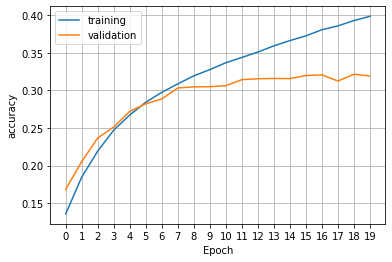

In [ ]:
# Plot accuracy

import matplotlib.pyplot as plt 
plt.plot(list(history['accuracy']), label='training')
plt.plot(list(history['val_accuracy']), label='validation')
#plt.plot(list(history['loss']), label='train_loss')
#plt.plot(list(history['val_loss']), label='val_loss')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,epochs,1))
plt.grid()
plt.show()

### Model with tokeniser

In [ ]:
epochs = 20
number_pics_per_batch = 30
train_steps = len(train_descriptions) // number_pics_per_batch
validation_steps = len(dev_descriptions) // number_pics_per_batch
history = list()

for i in range(epochs):
    train_generator = data_generator(
        train_descriptions, 
        train_image_features, 
        tokenizer,
        max_length, 
        vocab_size,
        number_pics_per_batch,
    )
    dev_generator = data_generator(
        dev_descriptions, 
        dev_image_features,
        tokenizer,
        max_length,
        vocab_size,
        number_pics_per_batch,
    )
    hist = base_model.fit(
        train_generator, 
        validation_data=dev_generator, 
        epochs=1, 
        steps_per_epoch=train_steps,
        validation_steps=validation_steps,
        verbose=1,
    )
    history.append({
        'loss': hist.history['loss'], 
        'val_loss': hist.history['val_loss'],
    })
    base_model.save('./base_model_weights/model_' + str(i) + '.h5')

In [ ]:
import matplotlib.pyplot as plt 

hist_df = pd.DataFrame(history)
plt.plot(list(hist_df['loss']), label='loss')
plt.plot(list(hist_df['val_loss']), label='val_loss')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0, epochs, 1))
plt.grid()
plt.show()

## 8 - Evaluate model

In [ ]:
# Greedy Search
def greedySearch(photo, model):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
def evaluate_model(model, descriptions, photos):
    actual, predicted = list(), list()
    stop_words = ['startseq','endseq']
    # step over the whole dataset
    for key, desc_list in descriptions.items():
        # generate descriptions
        yhat = greedySearch(photos[key].reshape((1,2048)), model)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        #actual.append(references)
        predicted.append(yhat.split())
        ref = [[word for word in nested if word not in stop_words] for nested in references]
        actual.append(ref)
        
    return actual, predicted
    
  # calculate BLEU scores

In [ ]:
# load training dataset (6K)
filename_test = 'data/Flickr_8k.testImages.txt'
test = load_set(filename_test)

In [ ]:
# prepare test set
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

# load dev images
test_features = load(open("data/pickle/encoded_test_images.pkl", "rb"))
print('Photos: test=%d' % len(test_features))

# descriptions
test_descriptions = load_clean_descriptions('data/descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))

# load token index wordtoix if needed (component of greedySearch in evaluate function)
#wordtoix = load(open("Pickle/wordtoix.pkl", "rb"))

# put .jpg back into dev_descriptions to match dev_features
test_descriptions = {k+'.jpg': v for k, v in test_descriptions.items()}

# load the model
# model.load_weights('./model_weights/model_30.h5')


Photos: test=1000
Descriptions: test=1000


In [ ]:
def print_scores(actual, predicted):
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))  


#### BEAM

In [ ]:
# BEAM Search
def flatten(lst):
    return sum(([x] if not isinstance(x, list) else flatten(x) for x in lst), [])

def generate_caption_beam(pred_model, caption_train_tokenizer, photo, max_length, vocab_size, beam_width):
    sequence = caption_train_tokenizer.texts_to_sequences(['startseq'])[0]
    sequence = pad_sequences([sequence], maxlen=max_length)
    model_softMax_output = np.squeeze(pred_model.predict([photo,sequence], verbose=0))
    most_likely_seq=np.argsort(model_softMax_output)[-beam_width:]
    most_likely_prob=np.log(model_softMax_output[most_likely_seq])


    most_likely_cap = list()
    for j in range(beam_width):
        most_likely_cap.append(list())
        most_likely_cap[j] =[[caption_train_tokenizer.index_word[most_likely_seq[j]]]]

    for i in range(max_length):    
        temp_prob = np.zeros((beam_width, vocab_size))
        for j in range(beam_width):
            if most_likely_cap[j][-1] != ['endseq']: #if not terminated
                num_words = len(most_likely_cap[j])
                sequence = caption_train_tokenizer.texts_to_sequences(most_likely_cap[j])
                sequence = pad_sequences(np.transpose(sequence), maxlen=max_length)
                model_softMax_output = pred_model.predict([photo,sequence], verbose=0)
                temp_prob[j,] = (1/(num_words)) *(most_likely_prob[j]*(num_words-1) + np.log(model_softMax_output)) #update most likily prob
            else:
                temp_prob[j,] = most_likely_prob[j] + np.zeros(vocab_size) - np.inf
                temp_prob[j,0] = most_likely_prob[j]


        x_idx, y_idx = np.unravel_index(temp_prob.flatten().argsort()[-beam_width:], temp_prob.shape)

        most_likely_cap_temp = list()
        for j in range(beam_width):
            most_likely_prob[j] = temp_prob[x_idx[j],y_idx[j]]
            most_likely_cap_temp.append(list())
            most_likely_cap_temp[j] = most_likely_cap[x_idx[j]].copy()
            if most_likely_cap_temp[j][-1] != ['endseq']:
                most_likely_cap_temp[j].append([caption_train_tokenizer.index_word[y_idx[j]]])

        most_likely_cap = most_likely_cap_temp.copy()

        finished = True
        for j in range(beam_width):
            if most_likely_cap_temp[j][-1] != ['endseq']:
                finished = False

        if finished == True:
            break

    final_caption = list()

    for j in range(beam_width):
        final_caption.append(' '.join(flatten(most_likely_cap[j][0:-1])))


    return final_caption, most_likely_prob


In [ ]:
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu


def get_one_with_highest_log_prob(captions, log_prob):
    return sorted([(c, p) for c, p in zip(captions, log_prob)], key=lambda x: x[1])[-1]


def bleu_evalulate(model, descriptions, image_features, beam_width=3):
    
    actual, predicted = list(), list()
    # step over the whole dataset
    for image_id, desc_list in tqdm(descriptions.items(), desc='Evaluating model with BLEU using Greedy Search'):
        captions, log_probs = generate_caption_beam(
            model,
            tokenizer,
            image_features[image_id].reshape((1, 2048)), 
            max_length, 
            vocab_size, 
            beam_width,
        )
        
        pred_cap, prob = get_one_with_highest_log_prob(captions, log_probs)
        
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(pred_cap.split())

    # calculate BLEU scores
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

## 9 - BLEU Score

Code for evaluation adapted from https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/


### BLEU with Greedy

In [ ]:
from keras.models import load_model
filename = 'data/model_weights/model_16.h5'
model = load_model(filename)
# evaluate model
#evaluate_model(model, dev_descriptions, dev_features)
actual, predicted = evaluate_model(model, test_descriptions, test_features)


/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [ ]:
# Print BLEU Scores
print_scores(actual, predicted)

BLEU-1: 0.522998
BLEU-2: 0.322659
BLEU-3: 0.230722
BLEU-4: 0.116544


### BLEU with BEAM

In [ ]:
from keras.models import load_model
model = load_model('data/model_weights/model_10.h5')
bleu_evalulate(model, test_descriptions, test_features, beam_width=10)

## 10 - ROUGE

ROUGE
ROUGE is a set of metric that generates the precision, recall, and F-score of a candidate with respect to references. ROUGE stands for Recall-Oriented Understudy for Gisting Evaluation. It is first proposed by Lin et al in their paper ROUGE: A Package for Automatic Evaluation of Summaries

ROUGE-N: measures n-gram overlap statistics
ROUGE-L: Longest Common Subsequence (LCS) based statistics. Longest common subsequence problem takes into account sentence level structure similarity naturally and identifies longest co-occurring in sequence n-grams automatically. An advantage of using LCS is that it does not require consecutive matches but in-sequence matches that reflect sentence level word order. Since it automatically includes longest in-sequence common n-grams, you don’t need a predefined n-gram length.
ROUGE-W: Weighted LCS-based statistics that favors consecutive LCSes
ROUGE-S – Is any pair of word in a sentence in order, allowing for arbitrary gaps. This can also be called skip-gram coocurrence. For example, skip-bigram measures the overlap of word pairs that can have a maximum of two gaps in between words. As an example, for the phrase “cat in the hat” the skip-bigrams would be “cat in, cat the, cat hat, in the, in hat, the hat”.
ROUGE-SU: Skip-bigram plus unigram-based co-occurrence statistics
SOurce - https://xiangyutang2.github.io/image-captioning/

In [ ]:
image_captions_candidate = dict()
for image_fileName, reference_captions in test_features.items():
    image_fileName_feature = image_fileName.split('.')[0]

    image_captions_candidate[image_fileName] = greedySearch(test_features[image_fileName].reshape((1,2048)), model)

#print(image_captions_candidate)  

In [ ]:
from rouge import Rouge
rouge = Rouge()
rouge_score = dict()
for image_fileName, reference_captions in test_descriptions.items():
    cand=[image_captions_candidate[image_fileName]]
    #ref_cap_reformat=list()
    #for cap in reference_captions:
    ref_cap_reformat = list(list(zip(reference_captions))[0]) 
      #ref_cap_reformat.append(' '.join(cap.split()[1:-1]))
    
    rouge_score[image_fileName] = rouge.get_scores(cand, ref_cap_reformat, avg=True)

#print(rouge_score)

In [ ]:
#rouge = Rouge()
rouge_score_1,rouge_score_2, rouge_score_3, rouge_score_4  = dict(), dict(), dict(), dict()
for image_fileName, reference_captions in test_descriptions.items():
    cand=[image_captions_candidate[image_fileName]]
    #ref_cap_reformat=list()
    #for cap in reference_captions:
    ref_cap_reformat = list(list(zip(reference_captions))[1]) 
    ref_cap_reformat1 = list(list(zip(reference_captions))[2]) 
    ref_cap_reformat2 = list(list(zip(reference_captions))[3]) 
    ref_cap_reformat3 = list(list(zip(reference_captions))[4]) 
      #ref_cap_reformat.append(' '.join(cap.split()[1:-1]))
    
    rouge_score_1[image_fileName] = rouge.get_scores(cand, ref_cap_reformat, avg=True)
    rouge_score_2[image_fileName] = rouge.get_scores(cand, ref_cap_reformat1, avg=True)
    rouge_score_3[image_fileName] = rouge.get_scores(cand, ref_cap_reformat2, avg=True)
    rouge_score_4[image_fileName] = rouge.get_scores(cand, ref_cap_reformat3, avg=True)

#print(rouge_score_1)

In [ ]:
def average_dicts(dicts):
    result = {}
    for i, d in enumerate(dicts):
        for k, v in d.items():
            update_dict_average(result, k, v, i)
    return result

def update_dict_average(current, key, update, n):
    if isinstance(update, dict):
        subcurrent = current.setdefault(key, {})
        for subkey, subupdate in update.items():
            update_dict_average(subcurrent, subkey, subupdate, n)
    else:
        current[key] = (current.get(key, 0) * n + update) / (n + 1)

result = {'avg_cap_1': average_dicts(rouge_score.values())}
#print(result)

result_1 = {'avg_cap_2': average_dicts(rouge_score_1.values())}
#print(result_1)

result_2 = {'avg_cap_3': average_dicts(rouge_score_2.values())}
#print(result_2)

result_3 = {'avg_cap_4': average_dicts(rouge_score_3.values())}
#print(result_3)

result_4 = {'avg_cap_5': average_dicts(rouge_score_4.values())}
#print(result_4)

cap_1 = pd.DataFrame.from_dict({(i,j): result[i][j] 
                           for i in result.keys() 
                           for j in result[i].keys()},
                       orient='index')

cap_2 = pd.DataFrame.from_dict({(i,j): result_1[i][j] 
                           for i in result_1.keys() 
                           for j in result_1[i].keys()},
                       orient='index')

cap_3 = pd.DataFrame.from_dict({(i,j): result_2[i][j] 
                           for i in result_2.keys() 
                           for j in result_2[i].keys()},
                       orient='index')

cap_4 = pd.DataFrame.from_dict({(i,j): result_3[i][j] 
                           for i in result_3.keys() 
                           for j in result_3[i].keys()},
                       orient='index')

cap_5 = pd.DataFrame.from_dict({(i,j): result_4[i][j] 
                           for i in result_4.keys() 
                           for j in result_4[i].keys()},
                       orient='index')

frames = [cap_1,cap_2, cap_3, cap_4, cap_5]
average_rouge = pd.concat(frames)

In [ ]:
rouge1, rouge2, rougel = 0, 0, 0
for i in (0,1,2,3,4):
    #print(frames[i]['f'][2])
    rouge1 += frames[i]['f'][0]
    rouge2 += frames[i]['f'][1]
    rougel += frames[i]['f'][2]

print("Rouge-1", (rouge1/5), "Rouge-2", (rouge2/5), "Rouge-L", (rougel/5))

Rouge-1 0.213673479872156 Rouge-2 0.05315125180853407 Rouge-L 0.20540728606700337


## 11 - Hyper-parameter tuning

In [ ]:
# Define Model

def model_tuning(dr, activ, unit, learn_rate):
    #from tensorflow.keras.layers import GRU, GlobalAveragePooling1D, Dropout, Dense, Embedding, Input, add
    #from tensorflow.keras.losses import SparseCategoricalCrossentropy
    #from tensorflow.keras.models import Model
    #from tensorflow.keras.optimizers import Adam
    from keras.layers import GRU, GlobalAveragePooling1D
    #from keras.losses import SparseCategoricalCrossentropy

    inputs1 = Input(shape=(2048,))
    
    fe1 = Dropout(rate= dr)(inputs1)
                  
    fe2 = Dense(units=lstm_output_size,
                activation = activ
                )(fe1)

    inputs2 = Input(shape=(max_length,))

    se1 = Embedding(vocab_size, embedding_dim, mask_zero=True, embeddings_initializer='glorot_uniform', 
                        weights=[embedding_matrix])(inputs2)

    se2 = GRU(lstm_output_size, return_sequences=True) (se1)
    se21 = Dropout(rate = dr)(se2)
    
    se3 = GRU(lstm_output_size, return_sequences=True) (se21)
    se4 = Dropout(rate=dr)(se3)
    
    se5 = GRU(lstm_output_size, return_sequences=True) (se4)

    decoder1 = add([fe2, se5])
    
    decoder2 = Dense(unit, 
                     activation = activ
                    )(decoder1)
                  
    flat = GlobalAveragePooling1D()(decoder2)
    outputs = Dense(vocab_size, activation='softmax')(flat)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)

    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr = learn_rate), metrics=['accuracy'])
    
    return model


In [ ]:
from tqdm import tqdm 

lstm_output_size = 300 
number_pics_per_batch = 120

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
val_generator = data_generator(val_descriptions, val_features, wordtoix, max_length, number_pics_per_batch)

tune = pd.DataFrame(columns=['dr','step','activ','accuracy','val_accuracy'])

for dr in tqdm((0.3,0.4,0.5)):
    for learn_rate in (.0001,.001,.0005):
        for activ in ('relu','tanh'):
            print (dr, learn_rate, activ)
            unit = 300
            
            epoch = 5
            step = 100
            model = model_tuning(dr, activ, unit, learn_rate)

            steps = len(train_descriptions)//step
            val_steps = len(val_descriptions)//step

            hist = model.fit_generator(generator, validation_data = val_generator, epochs=epoch, steps_per_epoch=steps, verbose=2, 
                                validation_steps = val_steps)
            tune.loc[len(tune) + 1] = (dr, step, activ, hist.history["accuracy"], hist.history["val_accuracy"])
            #get the highest validation accuracy of the training epochs
            '''filename = 'data/model_weights/model_19.h5'
            model = load_model(filename)
            # evaluate model
            #evaluate_model(model, dev_descriptions, dev_features)
            actual, predicted = evaluate_model(model, test_descriptions, test_features)'''

            validation_acc = np.amax(hist.history['val_accuracy']) 
            print('Best validation acc of epoch:', validation_acc)
            print ('loss', -validation_acc, 'model', model)




  0%|          | 0/3 [00:00<?, ?it/s]

0.3 0.0001 relu


/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
 - 83s - loss: 6.2458 - accuracy: 0.0972 - val_loss: 5.3920 - val_accuracy: 0.1168
Epoch 2/5
 - 81s - loss: 5.3468 - accuracy: 0.1298 - val_loss: 5.2207 - val_accuracy: 0.1422
Epoch 3/5
 - 80s - loss: 5.2089 - accuracy: 0.1427 - val_loss: 5.1516 - val_accuracy: 0.1458
Epoch 4/5
 - 80s - loss: 5.0776 - accuracy: 0.1503 - val_loss: 4.9904 - val_accuracy: 0.1530
Epoch 5/5
 - 80s - loss: 4.9599 - accuracy: 0.1553 - val_loss: 4.8162 - val_accuracy: 0.1559
Best validation acc of epoch: 0.15585187077522278
loss -0.15585187077522278 model <keras.engine.training.Model object at 0x7f9a416bcfd0>
0.3 0.0001 tanh


/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
 - 83s - loss: 6.2733 - accuracy: 0.0967 - val_loss: 5.5561 - val_accuracy: 0.1026
Epoch 2/5
 - 81s - loss: 5.4067 - accuracy: 0.1078 - val_loss: 5.3049 - val_accuracy: 0.1160
Epoch 3/5
 - 81s - loss: 5.2937 - accuracy: 0.1184 - val_loss: 5.2725 - val_accuracy: 0.1227
Epoch 4/5
 - 81s - loss: 5.2210 - accuracy: 0.1353 - val_loss: 5.1338 - val_accuracy: 0.1366
Epoch 5/5
 - 81s - loss: 5.1595 - accuracy: 0.1454 - val_loss: 5.1290 - val_accuracy: 0.1506
Best validation acc of epoch: 0.1505948156118393
loss -0.1505948156118393 model <keras.engine.training.Model object at 0x7f9a41032ef0>
0.3 0.001 relu


/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
 - 83s - loss: 5.4211 - accuracy: 0.1249 - val_loss: 5.0306 - val_accuracy: 0.1504
Epoch 2/5
 - 81s - loss: 4.7812 - accuracy: 0.1661 - val_loss: 4.5327 - val_accuracy: 0.1822
Epoch 3/5
 - 81s - loss: 4.3179 - accuracy: 0.1995 - val_loss: 4.1700 - val_accuracy: 0.2150
Epoch 4/5
 - 81s - loss: 3.9465 - accuracy: 0.2383 - val_loss: 3.8930 - val_accuracy: 0.2446
Epoch 5/5
 - 81s - loss: 3.7028 - accuracy: 0.2628 - val_loss: 3.8578 - val_accuracy: 0.2623
Best validation acc of epoch: 0.26226818561553955
loss -0.26226818561553955 model <keras.engine.training.Model object at 0x7f96841d2518>
0.3 0.001 tanh


/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
 - 83s - loss: 5.4834 - accuracy: 0.1179 - val_loss: 5.1548 - val_accuracy: 0.1433
Epoch 2/5
 - 81s - loss: 5.0365 - accuracy: 0.1517 - val_loss: 4.8957 - val_accuracy: 0.1555
Epoch 3/5
 - 81s - loss: 4.7635 - accuracy: 0.1710 - val_loss: 4.7097 - val_accuracy: 0.1806
Epoch 4/5
 - 80s - loss: 4.5099 - accuracy: 0.1950 - val_loss: 4.3576 - val_accuracy: 0.2053
Epoch 5/5
 - 80s - loss: 4.2854 - accuracy: 0.2152 - val_loss: 4.2303 - val_accuracy: 0.2196
Best validation acc of epoch: 0.21957366168498993
loss -0.21957366168498993 model <keras.engine.training.Model object at 0x7f9a4c686c88>
0.3 0.0005 relu


/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
 - 84s - loss: 5.5927 - accuracy: 0.1133 - val_loss: 5.1334 - val_accuracy: 0.1476
Epoch 2/5
 - 81s - loss: 4.9878 - accuracy: 0.1549 - val_loss: 4.8462 - val_accuracy: 0.1657
Epoch 3/5
 - 81s - loss: 4.6380 - accuracy: 0.1784 - val_loss: 4.5954 - val_accuracy: 0.1847
Epoch 4/5
 - 80s - loss: 4.3235 - accuracy: 0.2012 - val_loss: 4.2472 - val_accuracy: 0.2150
Epoch 5/5
 - 81s - loss: 4.0688 - accuracy: 0.2271 - val_loss: 3.9651 - val_accuracy: 0.2349
Best validation acc of epoch: 0.23492754995822906
loss -0.23492754995822906 model <keras.engine.training.Model object at 0x7f966b53dfd0>
0.3 0.0005 tanh


/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
 - 84s - loss: 5.5527 - accuracy: 0.1135 - val_loss: 5.2197 - val_accuracy: 0.1351
Epoch 2/5
 - 81s - loss: 5.1174 - accuracy: 0.1489 - val_loss: 4.8944 - val_accuracy: 0.1504
Epoch 3/5
 - 81s - loss: 4.9168 - accuracy: 0.1578 - val_loss: 4.8024 - val_accuracy: 0.1665
Epoch 4/5
 - 81s - loss: 4.7345 - accuracy: 0.1749 - val_loss: 4.6558 - val_accuracy: 0.1810
Epoch 5/5
 - 81s - loss: 4.5540 - accuracy: 0.1903 - val_loss: 4.5185 - val_accuracy: 0.1924





 33%|███▎      | 1/3 [40:52<1:21:44, 2452.40s/it]

Best validation acc of epoch: 0.19244533777236938
loss -0.19244533777236938 model <keras.engine.training.Model object at 0x7f966b237828>
0.4 0.0001 relu


/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
 - 83s - loss: 6.2266 - accuracy: 0.0967 - val_loss: 5.4013 - val_accuracy: 0.1193
Epoch 2/5
 - 80s - loss: 5.3760 - accuracy: 0.1249 - val_loss: 5.2610 - val_accuracy: 0.1326
Epoch 3/5
 - 81s - loss: 5.2157 - accuracy: 0.1406 - val_loss: 5.1321 - val_accuracy: 0.1465
Epoch 4/5
 - 81s - loss: 5.0815 - accuracy: 0.1492 - val_loss: 4.9863 - val_accuracy: 0.1515
Epoch 5/5
 - 81s - loss: 4.9538 - accuracy: 0.1565 - val_loss: 4.9270 - val_accuracy: 0.1590
Best validation acc of epoch: 0.1590130627155304
loss -0.1590130627155304 model <keras.engine.training.Model object at 0x7f9669fde518>
0.4 0.0001 tanh


/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
 - 83s - loss: 6.3086 - accuracy: 0.0960 - val_loss: 5.5171 - val_accuracy: 0.1027
Epoch 2/5
 - 81s - loss: 5.4069 - accuracy: 0.1085 - val_loss: 5.3016 - val_accuracy: 0.1176
Epoch 3/5
 - 81s - loss: 5.2992 - accuracy: 0.1181 - val_loss: 5.2749 - val_accuracy: 0.1180
Epoch 4/5
 - 81s - loss: 5.2263 - accuracy: 0.1259 - val_loss: 5.1442 - val_accuracy: 0.1409
Epoch 5/5
 - 81s - loss: 5.1861 - accuracy: 0.1456 - val_loss: 5.1309 - val_accuracy: 0.1490
Best validation acc of epoch: 0.14904360473155975
loss -0.14904360473155975 model <keras.engine.training.Model object at 0x7f966b94e860>
0.4 0.001 relu


/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
 - 83s - loss: 5.4204 - accuracy: 0.1261 - val_loss: 4.9590 - val_accuracy: 0.1527
Epoch 2/5
 - 81s - loss: 4.7623 - accuracy: 0.1680 - val_loss: 4.4882 - val_accuracy: 0.1810
Epoch 3/5
 - 81s - loss: 4.2826 - accuracy: 0.2046 - val_loss: 4.1349 - val_accuracy: 0.2231
Epoch 4/5
 - 81s - loss: 3.9410 - accuracy: 0.2388 - val_loss: 3.9378 - val_accuracy: 0.2449
Epoch 5/5
 - 81s - loss: 3.7051 - accuracy: 0.2623 - val_loss: 3.7665 - val_accuracy: 0.2671
Best validation acc of epoch: 0.2670876681804657
loss -0.2670876681804657 model <keras.engine.training.Model object at 0x7f9669acbf28>
0.4 0.001 tanh


/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
 - 83s - loss: 5.4287 - accuracy: 0.1249 - val_loss: 5.0331 - val_accuracy: 0.1493
Epoch 2/5
 - 81s - loss: 4.9822 - accuracy: 0.1541 - val_loss: 4.7995 - val_accuracy: 0.1603
Epoch 3/5
 - 80s - loss: 4.7302 - accuracy: 0.1741 - val_loss: 4.5639 - val_accuracy: 0.1828
Epoch 4/5
 - 80s - loss: 4.4458 - accuracy: 0.1999 - val_loss: 4.3240 - val_accuracy: 0.2066
Epoch 5/5
 - 81s - loss: 4.2319 - accuracy: 0.2173 - val_loss: 4.2642 - val_accuracy: 0.2206
Best validation acc of epoch: 0.2205842286348343
loss -0.2205842286348343 model <keras.engine.training.Model object at 0x7f966ac89470>
0.4 0.0005 relu


/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
 - 83s - loss: 5.5873 - accuracy: 0.1166 - val_loss: 5.1288 - val_accuracy: 0.1466
Epoch 2/5
 - 80s - loss: 5.0005 - accuracy: 0.1551 - val_loss: 4.8325 - val_accuracy: 0.1622
Epoch 3/5
 - 80s - loss: 4.6318 - accuracy: 0.1766 - val_loss: 4.3965 - val_accuracy: 0.1888
Epoch 4/5
 - 80s - loss: 4.3074 - accuracy: 0.2049 - val_loss: 4.0839 - val_accuracy: 0.2174
Epoch 5/5
 - 80s - loss: 4.0464 - accuracy: 0.2305 - val_loss: 4.0472 - val_accuracy: 0.2353
Best validation acc of epoch: 0.2353430539369583
loss -0.2353430539369583 model <keras.engine.training.Model object at 0x7f966933bb70>
0.4 0.0005 tanh


/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
 - 83s - loss: 5.5915 - accuracy: 0.1099 - val_loss: 5.2221 - val_accuracy: 0.1346
Epoch 2/5
 - 81s - loss: 5.1487 - accuracy: 0.1472 - val_loss: 5.0645 - val_accuracy: 0.1505
Epoch 3/5
 - 80s - loss: 4.9416 - accuracy: 0.1551 - val_loss: 4.7983 - val_accuracy: 0.1578
Epoch 4/5
 - 80s - loss: 4.7457 - accuracy: 0.1727 - val_loss: 4.6591 - val_accuracy: 0.1798
Epoch 5/5
 - 80s - loss: 4.5680 - accuracy: 0.1889 - val_loss: 4.5179 - val_accuracy: 0.1953





 67%|██████▋   | 2/3 [1:21:40<40:51, 2451.21s/it]

Best validation acc of epoch: 0.19530220329761505
loss -0.19530220329761505 model <keras.engine.training.Model object at 0x7f966a230080>
0.5 0.0001 relu


/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
 - 83s - loss: 6.2437 - accuracy: 0.0926 - val_loss: 5.3890 - val_accuracy: 0.1194
Epoch 2/5
 - 81s - loss: 5.3799 - accuracy: 0.1232 - val_loss: 5.2827 - val_accuracy: 0.1355
Epoch 3/5
 - 81s - loss: 5.2323 - accuracy: 0.1383 - val_loss: 5.1259 - val_accuracy: 0.1472
Epoch 4/5
 - 81s - loss: 5.1148 - accuracy: 0.1475 - val_loss: 5.0888 - val_accuracy: 0.1525
Epoch 5/5
 - 81s - loss: 5.0263 - accuracy: 0.1526 - val_loss: 4.9715 - val_accuracy: 0.1529
Best validation acc of epoch: 0.15285472571849823
loss -0.15285472571849823 model <keras.engine.training.Model object at 0x7f966899cf60>
0.5 0.0001 tanh


/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
 - 84s - loss: 6.2892 - accuracy: 0.0945 - val_loss: 5.5260 - val_accuracy: 0.1023
Epoch 2/5
 - 81s - loss: 5.3907 - accuracy: 0.1083 - val_loss: 5.3123 - val_accuracy: 0.1175
Epoch 3/5
 - 81s - loss: 5.2848 - accuracy: 0.1206 - val_loss: 5.2272 - val_accuracy: 0.1307
Epoch 4/5
 - 81s - loss: 5.2247 - accuracy: 0.1376 - val_loss: 5.1686 - val_accuracy: 0.1468
Epoch 5/5
 - 81s - loss: 5.1718 - accuracy: 0.1447 - val_loss: 5.1066 - val_accuracy: 0.1463
Best validation acc of epoch: 0.14678539335727692
loss -0.14678539335727692 model <keras.engine.training.Model object at 0x7f96471d1f28>
0.5 0.001 relu


/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
 - 83s - loss: 5.4155 - accuracy: 0.1251 - val_loss: 5.0309 - val_accuracy: 0.1520
Epoch 2/5
 - 81s - loss: 4.7744 - accuracy: 0.1675 - val_loss: 4.6365 - val_accuracy: 0.1807
Epoch 3/5
 - 81s - loss: 4.3187 - accuracy: 0.2011 - val_loss: 4.1784 - val_accuracy: 0.2183
Epoch 4/5
 - 81s - loss: 3.9890 - accuracy: 0.2335 - val_loss: 3.8634 - val_accuracy: 0.2427
Epoch 5/5
 - 81s - loss: 3.7589 - accuracy: 0.2572 - val_loss: 3.7575 - val_accuracy: 0.2628
Best validation acc of epoch: 0.2627532184123993
loss -0.2627532184123993 model <keras.engine.training.Model object at 0x7f96479e7550>
0.5 0.001 tanh


/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
 - 84s - loss: 5.4635 - accuracy: 0.1203 - val_loss: 5.0358 - val_accuracy: 0.1488
Epoch 2/5
 - 81s - loss: 4.9872 - accuracy: 0.1551 - val_loss: 4.8273 - val_accuracy: 0.1661
Epoch 3/5
 - 81s - loss: 4.7002 - accuracy: 0.1767 - val_loss: 4.5799 - val_accuracy: 0.1867
Epoch 4/5
 - 81s - loss: 4.4427 - accuracy: 0.1987 - val_loss: 4.4041 - val_accuracy: 0.2037
Epoch 5/5
 - 81s - loss: 4.2389 - accuracy: 0.2158 - val_loss: 4.1307 - val_accuracy: 0.2204
Best validation acc of epoch: 0.2203691005706787
loss -0.2203691005706787 model <keras.engine.training.Model object at 0x7f963ff914e0>
0.5 0.0005 relu


/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
 - 83s - loss: 5.5780 - accuracy: 0.1156 - val_loss: 5.1434 - val_accuracy: 0.1489
Epoch 2/5
 - 81s - loss: 5.0162 - accuracy: 0.1528 - val_loss: 4.8259 - val_accuracy: 0.1648
Epoch 3/5
 - 81s - loss: 4.6694 - accuracy: 0.1756 - val_loss: 4.4974 - val_accuracy: 0.1852
Epoch 4/5
 - 81s - loss: 4.3435 - accuracy: 0.2007 - val_loss: 4.3035 - val_accuracy: 0.2089
Epoch 5/5
 - 81s - loss: 4.1142 - accuracy: 0.2225 - val_loss: 4.0699 - val_accuracy: 0.2311
Best validation acc of epoch: 0.23112225532531738
loss -0.23112225532531738 model <keras.engine.training.Model object at 0x7f9647d86be0>
0.5 0.0005 tanh


/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
 - 83s - loss: 5.5790 - accuracy: 0.1115 - val_loss: 5.2024 - val_accuracy: 0.1336
Epoch 2/5
 - 81s - loss: 5.1585 - accuracy: 0.1423 - val_loss: 5.0877 - val_accuracy: 0.1495
Epoch 3/5
 - 81s - loss: 4.9779 - accuracy: 0.1549 - val_loss: 4.8196 - val_accuracy: 0.1557
Epoch 4/5
 - 81s - loss: 4.8141 - accuracy: 0.1664 - val_loss: 4.7164 - val_accuracy: 0.1714
Epoch 5/5
 - 80s - loss: 4.6378 - accuracy: 0.1856 - val_loss: 4.5391 - val_accuracy: 0.1914





100%|██████████| 3/3 [2:02:39<00:00, 2453.05s/it]

Best validation acc of epoch: 0.19144710898399353
loss -0.19144710898399353 model <keras.engine.training.Model object at 0x7f963eaede10>


In [ ]:
# Find the max accuracy
np.amax(tune['val_accuracy'])

[0.1527423858642578,
 0.18095757067203522,
 0.22310061752796173,
 0.2448965609073639,
 0.2670876681804657]

So we have about a 0.419 which means about 42% of words in the generated captions matched the original, and about 7% of generated 4-grams occured in the original. this is not a terrible score, but can likely be improved.

## 12 - Visual Comparision

Generate a few examples of generated captions with greedy vs beam, for visual inspection.   

**Please execute sections 1,2,4,and 5 before executing this section.**

In [28]:
# load base model for generating captions
from keras.models import load_model
model = load_model('data/model_weights/final_model.h5')

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [29]:
from glob import glob
from collections import defaultdict
from typing import Dict, List, Set, Tuple
from string import punctuation
import pickle

from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
from tqdm import tqdm

FLICKR8K_TEXT = 'data/'
FLICKR8K_DATASET = 'data/Flicker8k_Dataset'

def load_train_dev_test_image_paths(images_path_pattern: str, caption_dataset_path: str) -> Tuple[List[str]]:
    image_path_list = glob(images_path_pattern)

    train_images_path_list = get_common_image_path_list(
        image_path_list,
        f'{caption_dataset_path}/Flickr_8k.trainImages.txt',
    )
    dev_images_path_list = get_common_image_path_list(
        image_path_list,
        f'{caption_dataset_path}/Flickr_8k.devImages.txt',
    )
    test_images_path_list = get_common_image_path_list(
        image_path_list,
        f'{caption_dataset_path}/Flickr_8k.testImages.txt',
    )
    return train_images_path_list, dev_images_path_list, test_images_path_list


def get_common_image_path_list(image_path_list: List[str], splitted_image_names: List[str]) -> List[str]:
    with open(splitted_image_names) as f:
        splitted_image_ids = f.read().strip().split('\n')

    return [
        image_path for image_path in image_path_list
        if image_path.split('/')[-1] in splitted_image_ids
    ]


In [30]:

train_img_paths, dev_img_paths, test_img_paths = load_train_dev_test_image_paths(
    f'{FLICKR8K_DATASET}/*.jpg', 
    FLICKR8K_TEXT)

#print(train_img_paths, dev_img_paths, test_img_paths)

['data/Flicker8k_Dataset/536721406_884ab8fece.jpg', 'data/Flicker8k_Dataset/1763020597_d4cc8f0f8a.jpg', 'data/Flicker8k_Dataset/272156850_c4445a53f4.jpg', 'data/Flicker8k_Dataset/1449625950_fc9a8d02d9.jpg', 'data/Flicker8k_Dataset/210686241_b8e069fff3.jpg', 'data/Flicker8k_Dataset/3638631362_af29bbff01.jpg', 'data/Flicker8k_Dataset/3223809913_ae15d14d9a.jpg', 'data/Flicker8k_Dataset/451326127_2d95a2e1c2.jpg', 'data/Flicker8k_Dataset/426805536_d1d5e68c17.jpg', 'data/Flicker8k_Dataset/155221027_b23a4331b7.jpg', 'data/Flicker8k_Dataset/1801874841_4c12055e2f.jpg', 'data/Flicker8k_Dataset/430964917_022995afb6.jpg', 'data/Flicker8k_Dataset/1394599090_fe0ba238f0.jpg', 'data/Flicker8k_Dataset/3730457171_e66dde8c91.jpg', 'data/Flicker8k_Dataset/3618115051_41b5a7706c.jpg', 'data/Flicker8k_Dataset/3673035152_da7ed916d9.jpg', 'data/Flicker8k_Dataset/1299459562_ed0e064aee.jpg', 'data/Flicker8k_Dataset/3287236038_8998e6b82f.jpg', 'data/Flicker8k_Dataset/2987096101_a41896187a.jpg', 'data/Flicker8k_Da

In [34]:
# load test set for generation
def load_splitted_descriptions(full_descriptions_filename: str, splitted_image_ids: List[str]) -> Dict[str, List[str]]:
    doc = load_doc(full_descriptions_filename)
    descriptions = defaultdict(list)

    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], ' '.join(tokens[1:])
        if image_id in splitted_image_ids:
            descriptions[image_id].append(image_desc)

    return dict(descriptions)


test_image_ids = [img_path.split('/')[-1].split('.')[0] for img_path in test_img_paths]
test_descriptions = load_splitted_descriptions('data/descriptions.txt', test_image_ids)

with open("data/pickle/encoded_test_images.pkl", "rb") as encoded_pickle:
    test_image_features = load(encoded_pickle)

In [31]:
def flatten(lst):
    return sum(([x] if not isinstance(x, list) else flatten(x) for x in lst), [])

def generate_caption_beam(pred_model, caption_train_tokenizer, photo, max_length, vocab_size, beam_width):
    sequence = caption_train_tokenizer.texts_to_sequences(['startseq'])[0]
    sequence = pad_sequences([sequence], maxlen=max_length)
    model_softMax_output = np.squeeze(pred_model.predict([photo,sequence], verbose=0))
    most_likely_seq=np.argsort(model_softMax_output)[-beam_width:]
    most_likely_prob=np.log(model_softMax_output[most_likely_seq])


    most_likely_cap = list()
    for j in range(beam_width):
        most_likely_cap.append(list())
        most_likely_cap[j] =[[caption_train_tokenizer.index_word[most_likely_seq[j]]]]

    for i in range(max_length):    
        temp_prob = np.zeros((beam_width, vocab_size))
        for j in range(beam_width):
            if most_likely_cap[j][-1] != ['endseq']: #if not terminated
                num_words = len(most_likely_cap[j])
                sequence = caption_train_tokenizer.texts_to_sequences(most_likely_cap[j])
                sequence = pad_sequences(np.transpose(sequence), maxlen=max_length)
                model_softMax_output = pred_model.predict([photo,sequence], verbose=0)
                temp_prob[j,] = (1/(num_words)) *(most_likely_prob[j]*(num_words-1) + np.log(model_softMax_output)) #update most likily prob
            else:
                temp_prob[j,] = most_likely_prob[j] + np.zeros(vocab_size) - np.inf
                temp_prob[j,0] = most_likely_prob[j]


        x_idx, y_idx = np.unravel_index(temp_prob.flatten().argsort()[-beam_width:], temp_prob.shape)

        most_likely_cap_temp = list()
        for j in range(beam_width):
            most_likely_prob[j] = temp_prob[x_idx[j],y_idx[j]]
            most_likely_cap_temp.append(list())
            most_likely_cap_temp[j] = most_likely_cap[x_idx[j]].copy()
            if most_likely_cap_temp[j][-1] != ['endseq']:
                most_likely_cap_temp[j].append([caption_train_tokenizer.index_word[y_idx[j]]])

        most_likely_cap = most_likely_cap_temp.copy()

        finished = True
        for j in range(beam_width):
            if most_likely_cap_temp[j][-1] != ['endseq']:
                finished = False

        if finished == True:
            break

    final_caption = list()

    for j in range(beam_width):
        final_caption.append(' '.join(flatten(most_likely_cap[j][0:-1])))


    return final_caption, most_likely_prob


In [36]:
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu


def get_one_with_highest_log_prob(captions, log_prob):
    return sorted([(c, p) for c, p in zip(captions, log_prob)], key=lambda x: x[1])[-1]


def bleu_evalulate_v(model, descriptions, image_features, beam_width=3):
    
    actual, predicted = list(), list()
    # step over the whole dataset
    for image_id, desc_list in tqdm(descriptions.items(), desc='Evaluating model with BLEU using Greedy Search'):
        captions, log_probs = generate_caption_beam(
            model,
            tokenizer,
            image_features[image_id+'.jpg'].reshape((1, 2048)), 
            max_length, 
            vocab_size, 
            beam_width,
        )
        
        pred_cap, prob = get_one_with_highest_log_prob(captions, log_probs)
        
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(pred_cap.split())

    # calculate BLEU scores
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
    
#bleu_evalulate_v(model, test_descriptions, test_image_features, beam_width=1)

Evaluating model with BLEU using Greedy Search: 100%|██████████| 1000/1000 [03:20<00:00,  4.99it/s]


BLEU-1: 0.493503
BLEU-2: 0.292305
BLEU-3: 0.205592
BLEU-4: 0.103113


In [55]:
# Greedy Search
def greedySearch(photo, model):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [61]:
def evaluate_model(model, descriptions, photos):
    actual, predicted = list(), list()
    stop_words = ['startseq','endseq']
    # step over the whole dataset
    for key, desc_list in descriptions.items():
        # generate descriptions
        yhat = greedySearch(photos[key+'.jpg'].reshape((1,2048)), model)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        #actual.append(references)
        predicted.append(yhat.split())
        ref = [[word for word in nested if word not in stop_words] for nested in references]
        actual.append(ref)
        
    return actual, predicted

In [57]:
# calculate BLEU scores
def print_scores(actual, predicted):
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))  

In [ ]:
# BLEU scores with BEAM
bleu_evalulate_v(model, test_descriptions, test_image_features, beam_width=1)

Evaluating model with BLEU using Greedy Search: 100%|██████████| 1000/1000 [19:29<00:00,  1.17s/it]


BLEU-1: 0.441351
BLEU-2: 0.276391
BLEU-3: 0.203057
BLEU-4: 0.102023


In [ ]:
bleu_evalulate_v(model, test_descriptions, test_image_features, beam_width=3)

However, with beam search using 3 beam widths is slightly worse than the greedy search.

In [62]:
# BLEU scores with Greedy Search
actual, predicted = evaluate_model(model, test_descriptions, test_image_features)
print_scores = print_scores(actual, predicted)

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU-1: 0.057737
BLEU-2: 0.004632
BLEU-3: 0.000000
BLEU-4: 0.000000


**ROUGE scores**

In [65]:
image_captions_candidate = dict()
for image_fileName, reference_captions in test_image_features.items():
    image_fileName_feature = image_fileName.split('.')[0]

    image_captions_candidate[image_fileName] = greedySearch(test_image_features[image_fileName].reshape((1,2048)), model)

#print(image_captions_candidate)  

In [75]:
from rouge import Rouge
rouge = Rouge()
rouge_score = dict()
for image_fileName, reference_captions in test_descriptions.items():
    image_fileName = image_fileName + '.jpg'
    cand=[image_captions_candidate[image_fileName]]
    #ref_cap_reformat=list()
    #for cap in reference_captions:
    ref_cap_reformat = list(list(zip(reference_captions))[0]) 
      #ref_cap_reformat.append(' '.join(cap.split()[1:-1]))
    try:
        rouge_score[image_fileName] = rouge.get_scores(cand, ref_cap_reformat, avg=True)
    except:
        continue
            

#print(rouge_score)

In [80]:
#rouge = Rouge()
rouge_score_1,rouge_score_2, rouge_score_3, rouge_score_4  = dict(), dict(), dict(), dict()
for image_fileName, reference_captions in test_descriptions.items():
    cand=[image_captions_candidate[image_fileName+'.jpg']]
    #ref_cap_reformat=list()
    #for cap in reference_captions:
    ref_cap_reformat = list(list(zip(reference_captions))[1]) 
    ref_cap_reformat1 = list(list(zip(reference_captions))[2]) 
    ref_cap_reformat2 = list(list(zip(reference_captions))[3]) 
    ref_cap_reformat3 = list(list(zip(reference_captions))[4]) 
      #ref_cap_reformat.append(' '.join(cap.split()[1:-1]))
    try:
        rouge_score_1[image_fileName] = rouge.get_scores(cand, ref_cap_reformat, avg=True)
        rouge_score_2[image_fileName] = rouge.get_scores(cand, ref_cap_reformat1, avg=True)
        rouge_score_3[image_fileName] = rouge.get_scores(cand, ref_cap_reformat2, avg=True)
        rouge_score_4[image_fileName] = rouge.get_scores(cand, ref_cap_reformat3, avg=True)
    except:
        continue

#print(rouge_score_1)

In [81]:
def average_dicts(dicts):
    result = {}
    for i, d in enumerate(dicts):
        for k, v in d.items():
            update_dict_average(result, k, v, i)
    return result

def update_dict_average(current, key, update, n):
    if isinstance(update, dict):
        subcurrent = current.setdefault(key, {})
        for subkey, subupdate in update.items():
            update_dict_average(subcurrent, subkey, subupdate, n)
    else:
        current[key] = (current.get(key, 0) * n + update) / (n + 1)

result = {'avg_cap_1': average_dicts(rouge_score.values())}
#print(result)

result_1 = {'avg_cap_2': average_dicts(rouge_score_1.values())}
#print(result_1)

result_2 = {'avg_cap_3': average_dicts(rouge_score_2.values())}
#print(result_2)

result_3 = {'avg_cap_4': average_dicts(rouge_score_3.values())}
#print(result_3)

result_4 = {'avg_cap_5': average_dicts(rouge_score_4.values())}
#print(result_4)

cap_1 = pd.DataFrame.from_dict({(i,j): result[i][j] 
                           for i in result.keys() 
                           for j in result[i].keys()},
                       orient='index')

cap_2 = pd.DataFrame.from_dict({(i,j): result_1[i][j] 
                           for i in result_1.keys() 
                           for j in result_1[i].keys()},
                       orient='index')

cap_3 = pd.DataFrame.from_dict({(i,j): result_2[i][j] 
                           for i in result_2.keys() 
                           for j in result_2[i].keys()},
                       orient='index')

cap_4 = pd.DataFrame.from_dict({(i,j): result_3[i][j] 
                           for i in result_3.keys() 
                           for j in result_3[i].keys()},
                       orient='index')

cap_5 = pd.DataFrame.from_dict({(i,j): result_4[i][j] 
                           for i in result_4.keys() 
                           for j in result_4[i].keys()},
                       orient='index')

frames = [cap_1,cap_2, cap_3, cap_4, cap_5]
average_rouge = pd.concat(frames)

In [82]:
rouge1, rouge2, rougel = 0, 0, 0
for i in (0,1,2,3,4):
    #print(frames[i]['f'][2])
    rouge1 += frames[i]['f'][0]
    rouge2 += frames[i]['f'][1]
    rougel += frames[i]['f'][2]

print("Rouge-1", (rouge1/5), "Rouge-2", (rouge2/5), "Rouge-L", (rougel/5))

Rouge-1 0.03333136671232445 Rouge-2 0.00011803147977607466 Rouge-L 0.06303255211060421


## Using the best model, we generate captions with greedy and beam search

In [ ]:
# load best model for generating captions
from keras.models import load_model
model = load_model('data/model_weights/final_model.h5')
#model_beam = load_model('data/model_weights/final_model.h5')

In [49]:
actual_best, predicted_best = bleu_evalulate(model, test_descriptions, test_image_features, beam_width=1)


Evaluating model with BLEU using Greedy Search:   6%|▋         | 63/1000 [00:12<03:04,  5.07it/s]/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in log

Evaluating model with BLEU using Greedy Search:   8%|▊         | 78/1000 [00:15<03:07,  4.91it/s]


Evaluating model with BLEU using Greedy Search:  16%|█▌        | 158/1000 [00:32<03:03,  4.59it/s]


Evaluating model with BLEU using Greedy Search:  24%|██▍       | 244/1000 [00:49<02:35,  4.88it/s]


Evaluating model with BLEU using Greedy Search:  32%|███▎      | 325/1000 [01:05<02:30,  4.50it/s]


Evaluating model with BLEU using Greedy Search:  40%|████      | 405/1000 [01:21<01:56,  5.12it/s]


Evaluating model with BLEU using Greedy Search:  48%|████▊     | 485/1000 [01:37<01:37,  5.26it/s]


Evaluating model with BLEU using Greedy Search:  57%|█████▋    | 567/1000 [01:54<01:33,  4.61it/s]


Evaluating model with BLEU using Greedy Search:  65%|██████▌   | 650/1000 [02:10<00:57,  6.05it/s]


Evaluating model with BLEU using Greedy Search:  73%|███████▎  | 731/1000 [02:27<00:55,  4.84it/s]


Evaluating model with BLEU using Greedy Search:  81%|████████▏ | 813/1000 [02:42<00:33,  5.63it/s]


Evaluating model with BLEU using Greedy Search:  89%|████████▉ | 893/1000 [02:59<00:23,  4.62it/s]


Evaluating model with BLEU using Greedy Search:  97%|█████████▋| 974/1000 [03:15<00:06,  4.29it/s]


Evaluating model with BLEU using Greedy Search: 100%|██████████| 1000/1000 [03:20<00:00,  4.99it/s]


In [51]:
actual_bbeam, predicted_bbeam = bleu_evalulate(model, test_descriptions, test_image_features, beam_width=10)


Evaluating model with BLEU using Greedy Search:   1%|          | 10/1000 [00:18<29:01,  1.76s/it]/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in log

Evaluating model with BLEU using Greedy Search:   8%|▊         | 78/1000 [02:16<26:28,  1.72s/it]


Evaluating model with BLEU using Greedy Search:  16%|█▌        | 158/1000 [04:46<28:07,  2.00s/it]


Evaluating model with BLEU using Greedy Search:  24%|██▍       | 238/1000 [07:11<23:47,  1.87s/it]


Evaluating model with BLEU using Greedy Search:  32%|███▏      | 318/1000 [09:40<18:52,  1.66s/it]


Evaluating model with BLEU using Greedy Search:  40%|███▉      | 398/1000 [12:04<17:56,  1.79s/it]


Evaluating model with BLEU using Greedy Search:  48%|████▊     | 478/1000 [14:29<15:34,  1.79s/it]


Evaluating model with BLEU using Greedy Search:  56%|█████▌    | 558/1000 [16:54<13:45,  1.87s/it]


Evaluating model with BLEU using Greedy Search:  64%|██████▍   | 638/1000 [19:15<10:42,  1.78s/it]


Evaluating model with BLEU using Greedy Search:  72%|███████▏  | 718/1000 [21:40<08:09,  1.73s/it]


Evaluating model with BLEU using Greedy Search:  80%|███████▉  | 798/1000 [24:04<05:30,  1.63s/it]


Evaluating model with BLEU using Greedy Search:  88%|████████▊ | 878/1000 [26:26<03:48,  1.87s/it]


Evaluating model with BLEU using Greedy Search:  96%|█████████▌| 958/1000 [28:50<01:19,  1.89s/it]


Evaluating model with BLEU using Greedy Search: 100%|██████████| 1000/1000 [30:06<00:00,  1.81s/it]


In [52]:
predicted_best_dict = dict(zip(test_image_ids_list, predicted_best))

predicted_bbeam_dict = dict(zip(test_image_ids_list, predicted_bbeam))

i=0
while i < 10:

    print("Greedy caption: %s" % ' '.join(list(predicted_best_dict.values())[i]))
    print("Best beam caption: %s" % ' '.join(list(predicted_bbeam_dict.values())[i]))

    i = i+1

Greedy caption: man in red shirt is walking down the street
Best beam caption: young boy wearing red shirt is walking down the street
Greedy caption: boy is running through the water
Best beam caption: two boys are playing in the water
Greedy caption: man in red shirt is walking down the street
Best beam caption: couple are sitting on bench
Greedy caption: white and white dog is running through the grass
Best beam caption: tan and white dog is running through the grass
Greedy caption: boy is standing on the edge of the water
Best beam caption: young boy is playing in the water
Greedy caption: black and white dog is running through the grass
Best beam caption: dog is running through the grass
Greedy caption: white and white dog is running through the grass
Best beam caption: dog is running through the grass
Greedy caption: boy is sitting on the bed
Best beam caption: young boy is playing in the grass
Greedy caption: dog is running through the water
Best beam caption: two dogs are playin

Thus, we need to further evaluate with visual inspections.

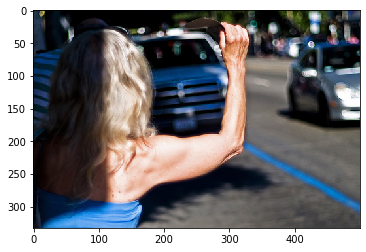

1056338697_4f7d7ce270
Actual captions: ['blond woman in blue shirt appears to wait for ride', 'blond woman is on the street hailing taxi', 'woman is signaling is to traffic as seen from behind', 'woman with blonde hair wearing blue tube top is waving on the side of the street', 'the woman in the blue dress is holding out her arm at oncoming traffic']
Greedy caption: man in red shirt is walking down the street
Best beam caption: young boy wearing red shirt is walking down the street


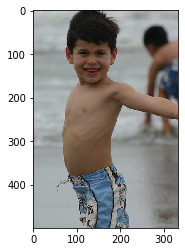

106490881_5a2dd9b7bd
Actual captions: ['boy in his blue swim shorts at the beach', 'boy smiles for the camera at beach', 'young boy in swimming trunks is walking with his arms outstretched on the beach', 'children playing on the beach', 'the boy is playing on the shore of an ocean']
Greedy caption: boy is running through the water
Best beam caption: two boys are playing in the water


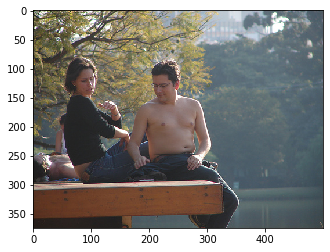

1082379191_ec1e53f996
Actual captions: ['lady and man with no shirt sit on dock', 'man and woman are sitting on dock together', 'man and woman sitting on dock', 'man and woman sitting on deck next to lake', 'shirtless man and woman sitting on dock']
Greedy caption: man in red shirt is walking down the street
Best beam caption: couple are sitting on bench


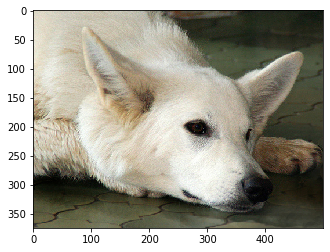

1084040636_97d9633581
Actual captions: ['closeup of white dog that is laying its head on its paws', 'large white dog lying on the floor', 'white dog has its head on the ground', 'white dog is resting its head on tiled floor with its eyes open', 'white dog rests its head on the patio bricks']
Greedy caption: white and white dog is running through the grass
Best beam caption: tan and white dog is running through the grass


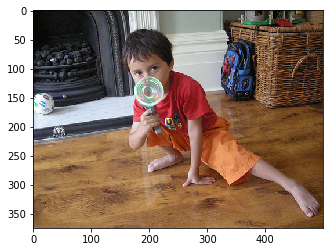

1096395242_fc69f0ae5a
Actual captions: ['boy with toy gun', 'little boy in orange shorts playing with toy', 'young boy with his foot outstretched aims toy at the camera in front of fireplace', 'young child plays with his new lightup toy', 'boy with toy gun pointed at the camera']
Greedy caption: boy is standing on the edge of the water
Best beam caption: young boy is playing in the water


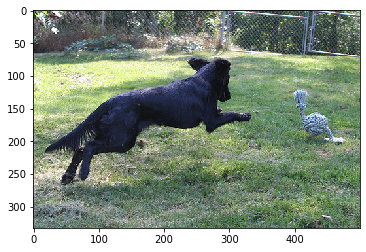

1107246521_d16a476380
Actual captions: ['black dog jumping to catch rope toy', 'black dog playing fetch with ball of rope', 'black dog pounces to get rope toy', 'black dog running after his rope toy', 'large black dog is playing in grassy yard']
Greedy caption: black and white dog is running through the grass
Best beam caption: dog is running through the grass


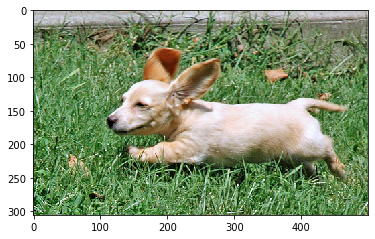

1119015538_e8e796281e
Actual captions: ['little tan dog with large ears running through the grass', 'playful dog is running through the grass', 'small dogs ears stick up as it runs in the grass', 'the small dog is running across the lawn', 'this is small beige dog running through grassy field']
Greedy caption: white and white dog is running through the grass
Best beam caption: dog is running through the grass


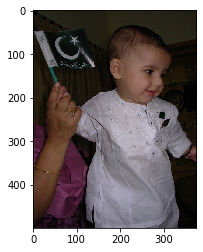

1122944218_8eb3607403
Actual captions: ['baby in white garment holds flag with crescent moon and star', 'baby is holding small black flag with moon and star on it', 'baby wearing white gown waves muslim flag', 'little toddler dressed in white is smiling while lady helps him wave flag', 'baby in white outfit holding black and white flag']
Greedy caption: boy is sitting on the bed
Best beam caption: young boy is playing in the grass


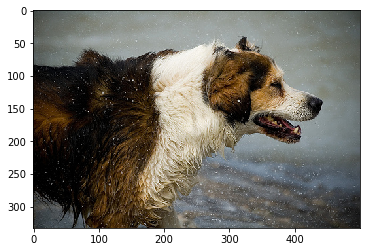

1131800850_89c7ffd477
Actual captions: ['brown and white dog stands outside while it snows', 'dog is looking at something near the water', 'furry dog attempts to dry itself by shaking the water off its coat', 'white and brown dog shaking its self dry', 'the large brown and white dog shakes off water']
Greedy caption: dog is running through the water
Best beam caption: two dogs are playing in the water


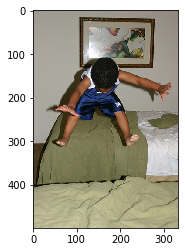

1131932671_c8d17751b3
Actual captions: ['boy is jumping on bed', 'boy jumped up from the green bed', 'boy jumps from one bed to another', 'small child is jumping on bed', 'the boy in blue shorts is bouncing on the bed']
Greedy caption: two boys are playing on bed
Best beam caption: baby is sitting on bed


In [54]:
# get comaprison for first 10
i=0
while i < 10:

    img_id = list(test_descriptions.keys())[i]
    x = plt.imread(f'{FLICKR8K_DATASET}/{img_id}.jpg')
    plt.imshow(x)
    plt.show()
    print(img_id)
    
    print("Actual captions: %s" % list(test_descriptions.values())[i])
    print("Greedy caption: %s" % ' '.join(list(predicted_dict.values())[i]))
    print("Best beam caption: %s" % ' '.join(list(predicted_bbeam_dict.values())[i]))



    i = i+1